# Portfolio Analysis - Minimum Variance Portfolios

This notebook implements minimum variance portfolios with:
- Three covariance estimation methods (single-factor, constant correlation, shrinkage)
- Portfolios with and without 3% upper bound constraint
- Turnover calculation for all strategies
- Comparison with benchmarks (equal-weight, value-weight)

## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize



Libraries imported successfully!


## 2. Load Data

In [2]:
# Load stock returns and market cap data
df = pd.read_csv('/Users/pbat/CMOR462Final/Data/monthlyreturncapitalization.csv')
df['Monthly Calendar Date'] = pd.to_datetime(df['Monthly Calendar Date'])
df = df.sort_values(['Ticker', 'Monthly Calendar Date'])
df = df.drop_duplicates(subset=['Ticker', 'Monthly Calendar Date'], keep='last')

returns = df.pivot(index='Monthly Calendar Date', columns='Ticker', values='Monthly Total Return')
mcap = df.pivot(index='Monthly Calendar Date', columns='Ticker', values='Monthly Market Capitalization')

# Load risk-free rate
rf = pd.read_csv('/Users/pbat/CMOR462Final/Data/riskfree.csv')
rf['Calendar Date'] = pd.to_datetime(rf['Calendar Date'])
rf = rf.set_index('Calendar Date')['90 Day Bill Returns']

# Load market returns
mkt = pd.read_csv('/Users/pbat/CMOR462Final/Data/marketreturn.csv')
mkt['Date'] = pd.to_datetime(mkt['Date'])
mkt = mkt.set_index('Date')['Total Market'].str.rstrip('%').astype(float) / 100

print(f"Returns shape: {returns.shape}")
print(f"Date range: {returns.index[0]} to {returns.index[-1]}")

Returns shape: (156, 50)
Date range: 2010-01-29 00:00:00 to 2022-12-30 00:00:00


/var/folders/l_/8zvg9_s54490f5lkvsgxjvjh0000gn/T/ipykernel_80253/2739658388.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Monthly Calendar Date'] = pd.to_datetime(df['Monthly Calendar Date'])
/var/folders/l_/8zvg9_s54490f5lkvsgxjvjh0000gn/T/ipykernel_80253/2739658388.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rf['Calendar Date'] = pd.to_datetime(rf['Calendar Date'])


## 3. Covariance Estimation Functions

In [ ]:
def estimate_covariance_sample(ret_window):
    """Sample covariance estimation."""
    return ret_window.cov()

def estimate_covariance_single_factor(ret_window, mkt_ret):
    """Single-factor (market model) covariance estimation."""
    betas = []
    residual_vars = []
    for col in ret_window.columns:
        y = ret_window[col].dropna()
        x = mkt_ret.loc[y.index]
        valid = ~(y.isna() | x.isna())
        y, x = y[valid], x[valid]
        if len(y) > 1:
            beta = np.cov(x, y)[0,1] / np.var(x)
            residual = y - beta * x
            residual_var = np.var(residual)
        else:
            beta = 0
            residual_var = np.var(y) if len(y) > 0 else 1e-4
        betas.append(beta)
        residual_vars.append(residual_var)
    
    betas = np.array(betas)
    var_mkt = np.var(mkt_ret.loc[ret_window.index].dropna())
    cov_matrix = np.outer(betas, betas) * var_mkt + np.diag(residual_vars)
    return pd.DataFrame(cov_matrix, index=ret_window.columns, columns=ret_window.columns)

def estimate_covariance_constant_corr(ret_window):
    """Constant correlation covariance estimation."""
    corr_matrix = ret_window.corr()
    avg_corr = corr_matrix.where(~np.eye(len(corr_matrix), dtype=bool)).stack().mean()
    std_devs = ret_window.std()
    n = len(std_devs)
    cov_matrix = np.outer(std_devs, std_devs) * avg_corr
    np.fill_diagonal(cov_matrix, std_devs**2)
    return pd.DataFrame(cov_matrix, index=ret_window.columns, columns=ret_window.columns)

def estimate_covariance_shrinkage(ret_window, delta=0.5):
    """Shrinkage covariance estimation."""
    sample_cov = ret_window.cov()
    std_devs = ret_window.std()
    avg_var = np.mean(np.diag(sample_cov))
    target = np.eye(len(std_devs)) * avg_var
    shrunk_cov = delta * target + (1 - delta) * sample_cov.values
    return pd.DataFrame(shrunk_cov, index=ret_window.columns, columns=ret_window.columns)



Covariance estimation functions defined!


## 4. Portfolio Optimization Functions

In [ ]:
def optimize_min_variance(cov_matrix, upper_bound=None):
    """Optimize minimum variance portfolio with optional upper bound constraint."""
    n = len(cov_matrix)
    
    def objective(w):
        return w @ cov_matrix.values @ w
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    # Add upper bound constraint if specified (e.g., 0.03 for 3% max per stock)
    if upper_bound is not None:
        bounds = tuple((0, upper_bound) for _ in range(n))
    else:
        bounds = tuple((0, 1) for _ in range(n))
    
    w0 = np.ones(n) / n
    
    result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    return pd.Series(result.x, index=cov_matrix.columns)

def calculate_turnover(w_old, w_new):
    """Calculate portfolio turnover: sum(|w_new - w_old|) / 2"""
    if w_old is None:
        return 0.0
    
    # Align indices - handle stocks that may enter or exit the universe
    all_stocks = w_old.index.union(w_new.index)
    
    # Create aligned weight vectors (missing stocks get 0 weight)
    w_old_aligned = pd.Series(0.0, index=all_stocks)
    w_new_aligned = pd.Series(0.0, index=all_stocks)
    
    w_old_aligned[w_old.index] = w_old
    w_new_aligned[w_new.index] = w_new
    
    turnover = np.abs(w_new_aligned - w_old_aligned).sum() / 2
    return turnover



Optimization functions defined!


## 5. Backtesting with Upper Bound Constraints and Turnover

In [11]:
estimation_window = 60
start_date = '2017-01-01'
end_date = '2022-12-31'

oos_dates = returns.loc[start_date:end_date].index

# Results storage - now includes 3% upper bound versions
results = {
    'sample': [],
    'single_factor': [],
    'constant_corr': [],
    'shrinkage': [],
    'single_factor_3pct': [],
    'constant_corr_3pct': [],
    'shrinkage_3pct': [],
    'equal_weight': [],
    'value_weight': []
}

# Track turnover for each strategy
turnovers = {key: [] for key in results.keys()}

# Track previous weights for turnover calculation
prev_weights = {key: None for key in results.keys()}

for i, date in enumerate(oos_dates):
    if i % 12 == 0:
        print(f"Processing {date.strftime('%Y-%m')}")
    
    date_idx = returns.index.get_loc(date)
    if date_idx < estimation_window:
        continue
    
    # Get estimation window
    ret_window = returns.iloc[date_idx - estimation_window:date_idx]
    ret_window = ret_window.dropna(axis=1, how='all')
    
    # Get out-of-sample returns
    ret_oos = returns.loc[date, ret_window.columns]
    
    # Get market returns for estimation window
    mkt_window = mkt.loc[ret_window.index]
    
    # Estimate covariance matrices
    cov_sample = estimate_covariance_sample(ret_window)
    cov_single = estimate_covariance_single_factor(ret_window, mkt_window)
    cov_const = estimate_covariance_constant_corr(ret_window)
    cov_shrink = estimate_covariance_shrinkage(ret_window)
    
    # Optimize portfolios WITHOUT upper bound
    w_sample = optimize_min_variance(cov_sample)
    w_single = optimize_min_variance(cov_single)
    w_const = optimize_min_variance(cov_const)
    w_shrink = optimize_min_variance(cov_shrink)
    
    # Optimize portfolios WITH 3% upper bound
    w_single_3pct = optimize_min_variance(cov_single, upper_bound=0.03)
    w_const_3pct = optimize_min_variance(cov_const, upper_bound=0.03)
    w_shrink_3pct = optimize_min_variance(cov_shrink, upper_bound=0.03)
    
    # Benchmark portfolios
    w_equal = pd.Series(1.0 / len(ret_window.columns), index=ret_window.columns)
    
    mcap_prev = mcap.iloc[date_idx - 1, :]
    mcap_prev = mcap_prev[ret_window.columns].fillna(0)
    w_value = mcap_prev / mcap_prev.sum()
    
    # Store all current weights
    current_weights = {
        'sample': w_sample,
        'single_factor': w_single,
        'constant_corr': w_const,
        'shrinkage': w_shrink,
        'single_factor_3pct': w_single_3pct,
        'constant_corr_3pct': w_const_3pct,
        'shrinkage_3pct': w_shrink_3pct,
        'equal_weight': w_equal,
        'value_weight': w_value
    }
    
    # Calculate returns and turnovers for all strategies
    for strategy, w in current_weights.items():
        # Portfolio return
        port_return = (w * ret_oos).sum()
        results[strategy].append((date, port_return))
        
        # Turnover
        turnover = calculate_turnover(prev_weights[strategy], w)
        turnovers[strategy].append(turnover)
        
        # Update previous weights
        prev_weights[strategy] = w



Processing 2017-01
Processing 2018-01
Processing 2019-01
Processing 2020-01
Processing 2021-01
Processing 2022-01


## 6. Process Results

In [13]:
# Convert results to DataFrame
portfolio_returns = {}
for strategy, res in results.items():
    portfolio_returns[strategy] = pd.Series([r[1] for r in res], index=[r[0] for r in res])

returns_df = pd.DataFrame(portfolio_returns)

print(f"\nStrategies: {list(returns_df.columns)}")
returns_df.head()


Strategies: ['sample', 'single_factor', 'constant_corr', 'shrinkage', 'single_factor_3pct', 'constant_corr_3pct', 'shrinkage_3pct', 'equal_weight', 'value_weight']


,sample,single_factor,constant_corr,shrinkage,single_factor_3pct,constant_corr_3pct,shrinkage_3pct,equal_weight,value_weight
2017-01-31,0.011701,0.000142,0.008440,0.017881,0.029834,0.026277,0.028274,0.036575,0.027794
2017-02-28,0.042147,0.052591,0.051289,0.045002,0.045092,0.045294,0.043671,0.048425,0.047394
2017-03-31,0.006714,0.007185,0.003315,0.006263,0.006861,0.003971,0.005810,0.010545,0.011642
2017-04-28,0.012797,0.010153,0.011164,0.015392,0.018677,0.017887,0.017260,0.017449,0.015667
2017-05-31,0.022589,0.031065,0.029475,0.029755,0.031567,0.024229,0.029942,0.027426,0.024527


## 7. Calculate Performance Metrics (Including Turnover)

In [14]:
def calculate_metrics(ret_series, rf_series):
    """Calculate performance metrics for a return series."""
    cumulative = (1 + ret_series).cumprod()
    total_return = cumulative.iloc[-1] - 1
    ann_return = (1 + total_return) ** (12 / len(ret_series)) - 1
    ann_vol = ret_series.std() * np.sqrt(12)
    
    rf_aligned = rf_series.loc[ret_series.index]
    excess = ret_series - rf_aligned
    sharpe = excess.mean() / excess.std() * np.sqrt(12)
    
    cummax = cumulative.cummax()
    drawdown = (cumulative - cummax) / cummax
    max_dd = drawdown.min()
    
    return {
        'Total Return': total_return,
        'Ann. Return': ann_return,
        'Ann. Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

# Calculate metrics for all strategies
metrics = {}
for strategy in returns_df.columns:
    metrics[strategy] = calculate_metrics(returns_df[strategy], rf)

metrics_df = pd.DataFrame(metrics).T

# Add average turnover to metrics
avg_turnovers = {strategy: np.mean(turnovers[strategy]) for strategy in turnovers.keys()}
metrics_df['Avg Turnover'] = pd.Series(avg_turnovers)

# Reorder columns for better readability
metrics_df = metrics_df[['Total Return', 'Ann. Return', 'Ann. Volatility', 
                         'Sharpe Ratio', 'Max Drawdown', 'Avg Turnover']]

metrics_df

,Total Return,Ann. Return,Ann. Volatility,Sharpe Ratio,Max Drawdown,Avg Turnover
sample,1.409011,0.157817,0.172699,0.869143,-0.237540,0.224487
single_factor,0.673228,0.089580,0.161839,0.541274,-0.326044,0.118811
constant_corr,1.079050,0.129737,0.135181,0.883111,-0.153209,0.100944
shrinkage,1.454963,0.161469,0.162621,0.931272,-0.223708,0.105866
single_factor_3pct,1.533977,0.167617,0.153822,1.009377,-0.203740,0.025053
constant_corr_3pct,1.512801,0.165985,0.151790,1.011475,-0.205210,0.028129
shrinkage_3pct,1.437709,0.160104,0.155186,0.959718,-0.201917,0.039523
equal_weight,1.924131,0.195821,0.175602,1.040595,-0.213848,0.000561
value_weight,1.453331,0.161340,0.179021,0.859550,-0.251509,0.022605


## 8. Visualizations

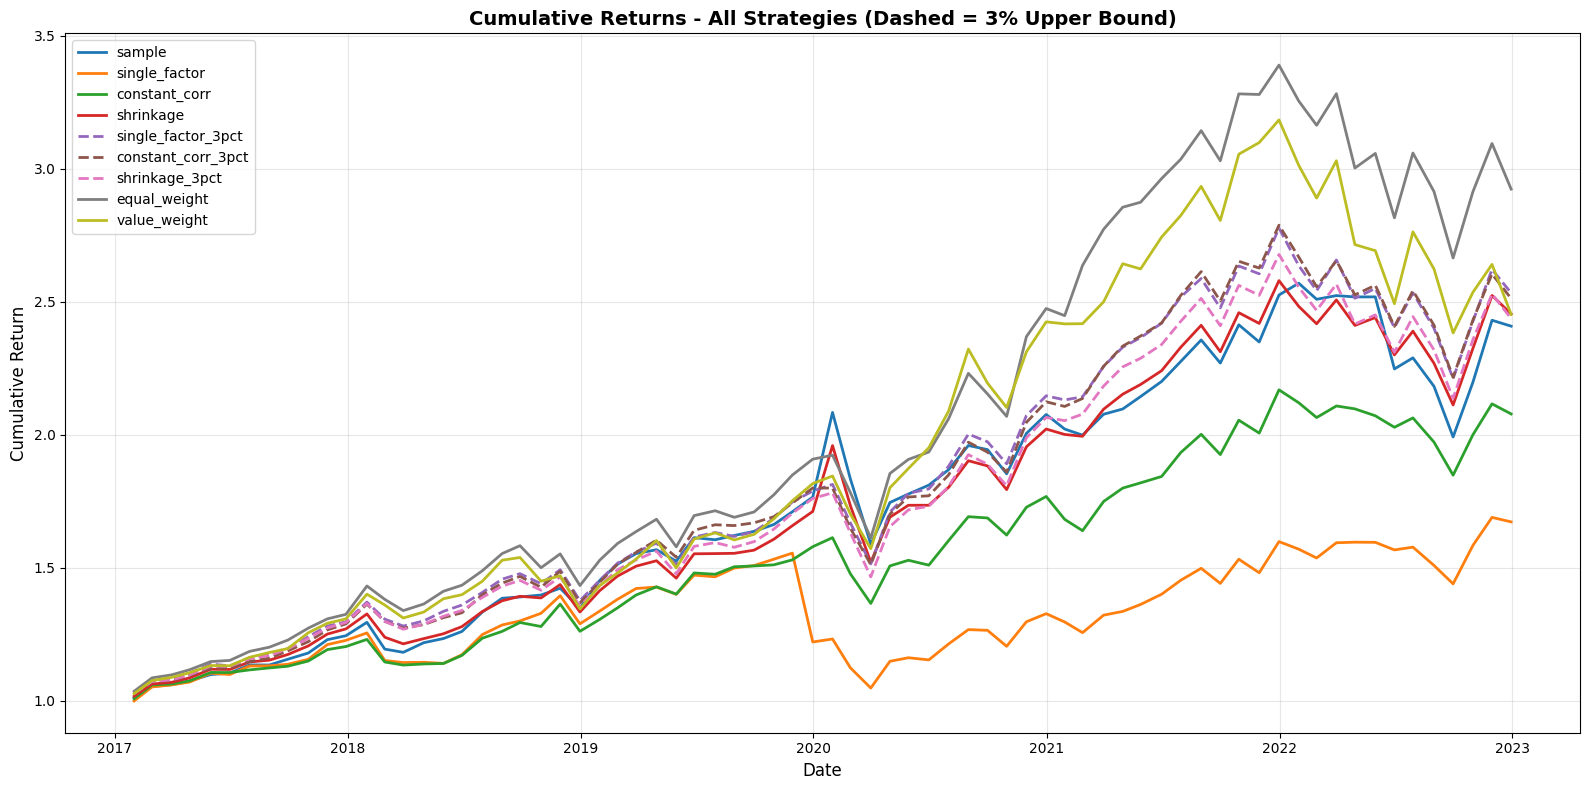

equal_weight          2.924131
single_factor_3pct    2.533977
constant_corr_3pct    2.512801
shrinkage             2.454963
value_weight          2.453331
shrinkage_3pct        2.437709
sample                2.409011
constant_corr         2.079050
single_factor         1.673228
Name: 2022-12-30 00:00:00, dtype: float64


In [ ]:
# Cumulative Returns Plot - All 9 Strategies
cumulative_returns = (1 + returns_df).cumprod()

plt.figure(figsize=(16, 8))
for col in cumulative_returns.columns:
    if '3pct' in col:
        plt.plot(cumulative_returns.index, cumulative_returns[col], 
                label=col, linewidth=2, linestyle='--')
    else:
        plt.plot(cumulative_returns.index, cumulative_returns[col], 
                label=col, linewidth=2)

plt.legend(loc='best', fontsize=10)
plt.title('Cumulative Returns - All Strategies (Dashed = 3% Upper Bound)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(cumulative_returns.iloc[-1].sort_values(ascending=False))

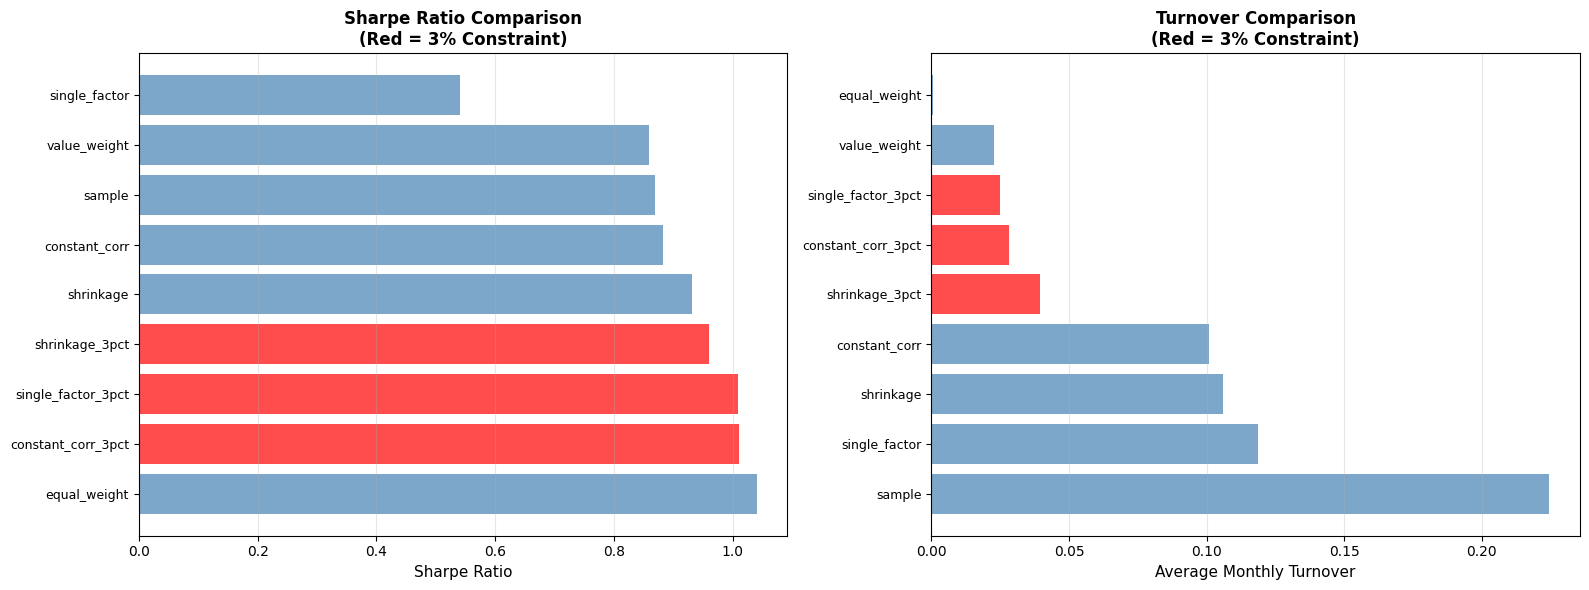

In [9]:
# Compare portfolios WITH and WITHOUT 3% constraint
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sharpe Ratio Comparison
sharpe_data = metrics_df['Sharpe Ratio'].sort_values(ascending=False)
colors = ['red' if '3pct' in idx else 'steelblue' for idx in sharpe_data.index]
axes[0].barh(range(len(sharpe_data)), sharpe_data.values, color=colors, alpha=0.7)
axes[0].set_yticks(range(len(sharpe_data)))
axes[0].set_yticklabels(sharpe_data.index, fontsize=9)
axes[0].set_xlabel('Sharpe Ratio', fontsize=11)
axes[0].set_title('Sharpe Ratio Comparison\n(Red = 3% Constraint)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Turnover Comparison
turnover_data = metrics_df['Avg Turnover'].sort_values(ascending=False)
colors = ['red' if '3pct' in idx else 'steelblue' for idx in turnover_data.index]
axes[1].barh(range(len(turnover_data)), turnover_data.values, color=colors, alpha=0.7)
axes[1].set_yticks(range(len(turnover_data)))
axes[1].set_yticklabels(turnover_data.index, fontsize=9)
axes[1].set_xlabel('Average Monthly Turnover', fontsize=11)
axes[1].set_title('Turnover Comparison\n(Red = 3% Constraint)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 10. Summary Table (Similar to Clarke et al. 2006 Exhibit 1)

In [ ]:
# Create summary table in format similar to Exhibit 1
# Returns in excess of risk-free rate, reported in basis points

summary_data = []

for strategy in returns_df.columns:
    ret_series = returns_df[strategy]
    rf_aligned = rf.loc[ret_series.index]
    excess = ret_series - rf_aligned
    
    # Monthly stats in basis points
    monthly_mean_bp = excess.mean() * 10000
    monthly_std_bp = excess.std() * 10000
    
    # Annualized stats
    ann_return = metrics_df.loc[strategy, 'Ann. Return'] * 100
    ann_vol = metrics_df.loc[strategy, 'Ann. Volatility'] * 100
    sharpe = metrics_df.loc[strategy, 'Sharpe Ratio']
    
    summary_data.append({
        'Strategy': strategy,
        'Monthly Mean (bp)': f'{monthly_mean_bp:.0f}',
        'Monthly Std Dev (bp)': f'{monthly_std_bp:.0f}',
        'Annualized Mean (%)': f'{ann_return:.1f}%',
        'Annualized Std Dev (%)': f'{ann_vol:.1f}%',
        'Sharpe Ratio': f'{sharpe:.2f}'
    })

summary_df = pd.DataFrame(summary_data)
print("\nPortfolio Return Statistics (returns in excess of risk-free rate)")
print(f"Period: {returns_df.index[0].strftime('%Y-%m')} to {returns_df.index[-1].strftime('%Y-%m')}")
print("\n")
summary_df

## 11. Restructured Summary Table (Matching Paper Format)

In [ ]:
# Restructured table to match Clarke et al. 2006 format
# Group by estimation method, show unconstrained vs constrained

print("
EXHIBIT: Portfolio Return Statistics 2017-2022")
print("(returns in excess of risk-free rate)
")

# Calculate stats for each strategy
def get_stats(strategy_name):
    ret_series = returns_df[strategy_name]
    rf_aligned = rf.loc[ret_series.index]
    excess = ret_series - rf_aligned
    
    monthly_mean_bp = excess.mean() * 10000
    monthly_std_bp = excess.std() * 10000
    ann_return = metrics_df.loc[strategy_name, 'Ann. Return'] * 100
    ann_vol = metrics_df.loc[strategy_name, 'Ann. Volatility'] * 100
    sharpe = metrics_df.loc[strategy_name, 'Sharpe Ratio']
    
    return {
        'Monthly Mean (bp)': int(round(monthly_mean_bp)),
        'Monthly Std Dev (bp)': int(round(monthly_std_bp)),
        'Annualized Mean': f"{ann_return:.1f}%",
        'Annualized Std Dev': f"{ann_vol:.1f}%",
        'Sharpe Ratio': f"{sharpe:.2f}"
    }

# Build the table data
table_data = []

# Market benchmark (equal-weight as proxy)
table_data.append(['Market (Equal-Weight Benchmark)', '', '', '', '', ''])
stats = get_stats('equal_weight')
table_data.append(['', stats['Monthly Mean (bp)'], stats['Monthly Std Dev (bp)'], 
                   stats['Annualized Mean'], stats['Annualized Std Dev'], stats['Sharpe Ratio']])

# Single-Factor Model
table_data.append(['', '', '', '', '', ''])
table_data.append(['Min-Var: Single-Factor Model', '', '', '', '', ''])
stats = get_stats('single_factor')
table_data.append(['  Unconstrained', stats['Monthly Mean (bp)'], stats['Monthly Std Dev (bp)'], 
                   stats['Annualized Mean'], stats['Annualized Std Dev'], stats['Sharpe Ratio']])
stats = get_stats('single_factor_3pct')
table_data.append(['  3% Upper Bound', stats['Monthly Mean (bp)'], stats['Monthly Std Dev (bp)'], 
                   stats['Annualized Mean'], stats['Annualized Std Dev'], stats['Sharpe Ratio']])

# Constant Correlation
table_data.append(['', '', '', '', '', ''])
table_data.append(['Min-Var: Constant Correlation', '', '', '', '', ''])
stats = get_stats('constant_corr')
table_data.append(['  Unconstrained', stats['Monthly Mean (bp)'], stats['Monthly Std Dev (bp)'], 
                   stats['Annualized Mean'], stats['Annualized Std Dev'], stats['Sharpe Ratio']])
stats = get_stats('constant_corr_3pct')
table_data.append(['  3% Upper Bound', stats['Monthly Mean (bp)'], stats['Monthly Std Dev (bp)'], 
                   stats['Annualized Mean'], stats['Annualized Std Dev'], stats['Sharpe Ratio']])

# Shrinkage
table_data.append(['', '', '', '', '', ''])
table_data.append(['Min-Var: Shrinkage Estimator', '', '', '', '', ''])
stats = get_stats('shrinkage')
table_data.append(['  Unconstrained', stats['Monthly Mean (bp)'], stats['Monthly Std Dev (bp)'], 
                   stats['Annualized Mean'], stats['Annualized Std Dev'], stats['Sharpe Ratio']])
stats = get_stats('shrinkage_3pct')
table_data.append(['  3% Upper Bound', stats['Monthly Mean (bp)'], stats['Monthly Std Dev (bp)'], 
                   stats['Annualized Mean'], stats['Annualized Std Dev'], stats['Sharpe Ratio']])

# Value-Weight Benchmark
table_data.append(['', '', '', '', '', ''])
table_data.append(['Value-Weighted Benchmark', '', '', '', '', ''])
stats = get_stats('value_weight')
table_data.append(['', stats['Monthly Mean (bp)'], stats['Monthly Std Dev (bp)'], 
                   stats['Annualized Mean'], stats['Annualized Std Dev'], stats['Sharpe Ratio']])

# Create DataFrame
exhibit_df = pd.DataFrame(table_data, columns=[
    'Strategy', 'Monthly Mean (bp)', 'Monthly Std Dev (bp)', 
    'Annualized Mean', 'Annualized Std Dev', 'Sharpe Ratio'
])

exhibit_df